### Search STAC to see what data is available

In [1]:
import json
from pathlib import Path

from pystac.client import Client
import geopandas as gpd


In [2]:
# Load the area of interest

geojson_path = Path("ff_domain.geojson")
gdf = gpd.read_file(geojson_path)

# Create connection to STAC Catalog

stac_url = 'https://ndp-test.sdsc.edu/stac'
catalog = Client.open(stac_url)

# Search STAC for items interesecting with area of interest
search_results = catalog.search(
    bbox=gdf.total_bounds
)

# Display matching items
print('Catalog entries in area of interest:')
for item in search_results.items():
    print(item.id)



Catalog entries in area of interest:
CALNU-0039-20250810
CALNU-0037-20250810
CALNU-0036-20250810
CALNU-0034-20250810
CALNU-0042-20250809
CALNU-0041-20250809
CALNU-0040-20250809
CALNU-0038-20250809
CALNU-0033-20250809
CALNU-0032-20250808
CALNU-0031-20250808
CALNU-0029-20250808
CALNU-0028-20250808
CALNU-0046-20250806
CALNU-0045-20250806
CALNU-0044-20250806
CALNU-0005-20250806
CALNU-0004-20250806
CALNU-0032-20241110
CALNU-0029-20241110
CALNU-0028-20241110
CALNU-0039-20241109
CALNU-0037-20241109
CALNU-0036-20241109
CALNU-0034-20241109
CALNU-0033-20241109
CALNU-0031-20241109
CALNU-0045-20241108
CALNU-0042-20241108
CALNU-0041-20241108
CALNU-0040-20241108
CALNU-0038-20241108
CALNU-0046-20241107
CALNU-0044-20241107
meta-canopy-height-maps
usda-treemap-2022
usda-treemap-2020
usda-treemap-2016
california_statewide_30m_slope_epsg3310
california_statewide_30m_skewness_first_epsg3310
california_statewide_30m_sd_first_epsg3310
california_statewide_30m_p99_first_epsg3310
california_statewide_30m_p95_

### Generate FastFuels Tiles

In [3]:
import os
os.environ["FASTFUELS_API_KEY"] = "test-api-key"
from fastfuels_sdk.domains import Domain
from fastfuels_sdk.features import Features
from fastfuels_sdk.grids import TopographyGridBuilder
from fastfuels_sdk.inventories import Inventories
from fastfuels_sdk.grids import TreeGridBuilder
from fastfuels_sdk.grids import SurfaceGridBuilder
from fastfuels_sdk.grids import Grids

import geopandas as gpd
from pathlib import Path



In [4]:
def create_fastfuels(boundary, site_name, product, 
                    version, interpolation_method, 
                    curing_live_herbaceous, curing_live_woody, 
                    groups, feature_masks, remove_non_burnable, 
                    uniform_fuel_moisture_value, grid_data_zip_path, live_fuel_moisture,
                    tree_inventory_save_path, grid_data_qf_path,
                    meta = False, tree_inventory = False, tree_inventory_path = None,
                    horizontal_resolution=2.0, vertical_resolution=1.0):
    # Create domain
    domain = Domain.from_geodataframe(
    geodataframe=boundary,
    name=site_name,
    description=f"domain of {site_name}",
    horizontal_resolution=horizontal_resolution,  # Use the argument
    vertical_resolution=vertical_resolution       # Use the argument
    )
    print(f"Created domain with ID: {domain.id}")
    
    
    # Initialize Features for our domain
    features = Features.from_domain_id(domain.id)
    
    # Initialize grids for our domain
    grids = Grids.from_domain_id(domain.id)
    
    # Create features from OpenStreetMap
    road_feature = features.create_road_feature_from_osm()
    water_feature = features.create_water_feature_from_osm()
    
    # Wait for features to be ready
    road_feature.wait_until_completed()
    water_feature.wait_until_completed()
    
    print("created road and water")
    
    # Create a feature grid with roads and water bodies
    feature_grid = grids.create_feature_grid(
        attributes=["road", "water"]
    )
    feature_grid.wait_until_completed()
    print("created feature grid")
    
    topography_grid = (
        TopographyGridBuilder(domain_id=domain.id)
        .with_elevation_from_3dep()
        .with_slope_from_3dep()
        .with_aspect_from_3dep()
        .build()
    )
    
    topography_grid.wait_until_completed()
    print("created topo")
    
    # if tree meta flag is true (you want to use a meta as the tree inventory)
    if meta:
        tree_inventory = Inventories.from_domain_id(
            domain.id
        ).create_tree_inventory_from_treemap(
            feature_masks=feature_masks,
            canopy_height_map_source = 'Meta2024'
        )
        tree_inventory.wait_until_completed(step = 1, verbose = True)
        print("created tree")
    
    
    # else Create tree inventory
    else:
        if use_tree_inventory:
            tree_inventory = Inventories.from_domain_id(
                        domain.id
                    ).create_tree_inventory_from_file_upload(
                        # feature_masks=feature_masks,
                        file_path=(tree_inventory_path)
                    )
            tree_inventory.wait_until_completed(step = 1, verbose = True)
            print("created tree using csv tree inventory")
            
        else:
            tree_inventory = Inventories.from_domain_id(
                domain.id
            ).create_tree_inventory_from_treemap(
                feature_masks=feature_masks
            )
            tree_inventory.wait_until_completed(step = 1, verbose = True)
            print("created tree")

    #export tree inventory
    export = tree_inventory.create_export("csv")  # or "parquet" or "geojson"
    export = export.wait_until_completed()
    
    # Download to specific file
    export.to_file(tree_inventory_save_path)
    
    # Create tree grid
    tree_grid = (
        TreeGridBuilder(domain_id=domain.id)
        .with_bulk_density_from_tree_inventory()
        .with_spcd_from_tree_inventory()
        .with_uniform_fuel_moisture(live_fuel_moisture)
        .build()
    )
    tree_grid.wait_until_completed(step = 1, verbose = True)
    
    print("created treegrid")
    
    # Create surface grid
    surface_grid = (
        SurfaceGridBuilder(domain_id=domain.id)
        .with_fuel_load_from_landfire(
            product=product,
            version=version,
            interpolation_method=interpolation_method,
            curing_live_herbaceous=curing_live_herbaceous,
            curing_live_woody=curing_live_woody,
            groups=groups,
            feature_masks=feature_masks,
            remove_non_burnable=remove_non_burnable,
        )
        .with_fuel_depth_from_landfire(
            product=product,
            version=version,
            interpolation_method=interpolation_method,
            feature_masks=feature_masks,
            remove_non_burnable=remove_non_burnable,
        )
        .with_uniform_fuel_moisture(
            value=uniform_fuel_moisture_value,
            feature_masks=feature_masks
        )
        .with_savr_from_landfire(
            product=product,
            version=version,
            interpolation_method=interpolation_method,
            groups=groups,
            feature_masks=feature_masks,
            remove_non_burnable=remove_non_burnable
        )
        .build()
    )
    surface_grid.wait_until_completed(step = 1, verbose = True)
    print("created surface")
    
    # Create the export
    export = grids.create_export("zarr") #"zarr" or "QUICFire"
    
    # Wait for the export to complete
    export.wait_until_completed()
    print('exported')
    
    # Save to a file
    export.to_file(grid_data_zip_path)

    export = grids.create_export("QUIC-Fire") #"zarr" or "QUIC-Fire"
    
    # Wait for the export to complete
    export.wait_until_completed()
    print('exported')
    # Save to a file
    export.to_file(grid_data_qf_path)


In [5]:
# set the parameters to create the fastfuels 
boundary = gpd.read_file('ff_domain.geojson')
boundary = boundary.to_crs(5070)
site_name = 'sitename'
product="FBFM40"
version='2022'
interpolation_method='zipper'
curing_live_herbaceous=0.25
curing_live_woody=0.1
groups = ['oneHour']
feature_masks=["road", "water"]
remove_non_burnable=["NB1", "NB2"]
uniform_fuel_moisture_value=15
live_fuel_moisture=106
use_tree_inventory = False
tree_inventory_path = None
horizontal_resolution=2.0
vertical_resolution=1.0



#### Workflow 1: TreeMap Plot Imputation
Create a tree inventory using TreeMap's nationwide coverage with default settings.


In [6]:

grid_data_zip_path = 'workflow_1_treemap.zarr.zip' #'/path/to/.zip/file' #fuels-array.zip - this is what you want to export the zarr file as
grid_data_qf_path = 'workflow_1_treemap.qf.zip'
tree_inventory_save_path = 'tree_inventory_1_export.csv'

create_fastfuels(boundary, site_name, product, 
                    version, interpolation_method, 
                    curing_live_herbaceous, curing_live_woody, 
                    groups, feature_masks, remove_non_burnable, 
                    uniform_fuel_moisture_value, grid_data_zip_path, live_fuel_moisture,
                    tree_inventory_save_path, grid_data_qf_path)

Created domain with ID: 3fe9c3dd901e4b258b8142c1071b32b5
created road and water
created feature grid
created topo
Tree inventory has status `JobStatus.PENDING` (1.00s)
Tree inventory has status `JobStatus.PENDING` (2.00s)
Tree inventory has status `JobStatus.PENDING` (3.00s)
Tree inventory has status `JobStatus.PENDING` (4.00s)
Tree inventory has status `JobStatus.PENDING` (5.00s)
Tree inventory has status `JobStatus.PENDING` (6.00s)
Tree inventory has status `JobStatus.PENDING` (7.00s)
Tree inventory has status `JobStatus.PENDING` (8.00s)
Tree inventory has status `JobStatus.PENDING` (9.00s)
Tree inventory has status `JobStatus.PENDING` (10.00s)
Tree inventory has status `JobStatus.PENDING` (11.00s)
Tree inventory has status `JobStatus.PENDING` (12.00s)
Tree inventory has status `JobStatus.PENDING` (13.00s)
Tree inventory has status `JobStatus.PENDING` (14.00s)
Tree inventory has status `JobStatus.PENDING` (15.00s)
Tree inventory has status `JobStatus.PENDING` (16.00s)
Tree inventory 


#### Workflow 2: Data Fusion (TreeMap + Meta2024)

Create a tree inventory using TreeMap with high-resolution Meta2024 canopy height data for improved tree height estimates.


In [7]:
grid_data_zip_path = 'workflow_2_meta.zarr.zip' #'/path/to/.zip/file' #fuels-array.zip - this is what you want to export the zarr file as
grid_data_qf_path = 'workflow_2_meta.qf.zip'
tree_inventory_save_path = 'tree_inventory_2_export.csv'
meta = True

create_fastfuels(boundary, site_name, product, 
                    version, interpolation_method, 
                    curing_live_herbaceous, curing_live_woody, 
                    groups, feature_masks, remove_non_burnable, 
                    uniform_fuel_moisture_value, grid_data_zip_path, live_fuel_moisture,
                    tree_inventory_save_path, grid_data_qf_path,
                    meta = meta)

Created domain with ID: 24ad5cf38cbb4d7c9828e98038c697eb
created road and water
created feature grid
created topo
Tree inventory has status `JobStatus.PENDING` (1.00s)
Tree inventory has status `JobStatus.PENDING` (2.00s)
Tree inventory has status `JobStatus.PENDING` (3.00s)
Tree inventory has status `JobStatus.PENDING` (4.00s)
Tree inventory has status `JobStatus.PENDING` (5.00s)
Tree inventory has status `JobStatus.PENDING` (6.00s)
Tree inventory has status `JobStatus.PENDING` (7.00s)
Tree inventory has status `JobStatus.PENDING` (8.00s)
Tree inventory has status `JobStatus.PENDING` (9.00s)
Tree inventory has status `JobStatus.PENDING` (10.00s)
Tree inventory has status `JobStatus.PENDING` (11.00s)
Tree inventory has status `JobStatus.PENDING` (12.00s)
Tree inventory has status `JobStatus.PENDING` (13.00s)
Tree inventory has status `JobStatus.PENDING` (14.00s)
Tree inventory has status `JobStatus.PENDING` (15.00s)
Tree inventory has status `JobStatus.PENDING` (16.00s)
Tree inventory 

### Send to BurnPro3D

In [8]:
import bp3d
import shutil
import zipfile
from scipy.io import FortranFile 
import numpy as np
import zarr

In [9]:

def edit_dat(array_sz, gui_dir, file, zarrname, zipname = 'fuel-array.zip', fuel_moisture = None):
    '''
    for editing the .dat files
    '''
    edited_ff = zarr.open(zipname)
    #initialize np.zero array in z, y, x
    arr = np.zeros((array_sz['z'], array_sz['y'], array_sz['x']), dtype = 'float32')

    #read the zarr array for the surface and save to the blank array

    if zarrname == 'SAVR':
        zarrarray_surface = (edited_ff['surface'][zarrname]['oneHour'][...])
        arr[0,:,:] = zarrarray_surface[:array_sz['y'], :array_sz['x']]
        arr[arr != 0] = 2/arr[arr != 0]
        arr[0,:,:] = np.fliplr(2/zarrarray_surface[:array_sz['y'], :array_sz['x']])

    if zarrname == 'fuelDepth':
        zarrarray_surface = (edited_ff['surface'][zarrname][...])
        arr[0,:,:] = np.fliplr(zarrarray_surface[:array_sz['y'], :array_sz['x']])
    

    if zarrname == 'fuelMoisture':
        zarrarray_surface = (edited_ff['surface'][zarrname][...])
        zarrarray_canopy = edited_ff['tree'][zarrname][...]

        zarrarray_canopy_flipped = np.zeros((array_sz['z'], array_sz['y'], array_sz['x']), dtype = 'float32')

        for zi in np.arange(0, array_sz['z']):
            zarrarray_canopy_flipped[zi, :,:] = (np.fliplr(zarrarray_canopy[zi,:,:]))#np.flip(zarrarray_canopy[zi,:,:], len(zarrarray_canopy[zi,:,:].shape) - 2)
        
        # # Change canopy to ny,nx,nz from nz,ny,nx

        arr[0,:,:] = zarrarray_surface[:array_sz['y'], :array_sz['x']]
        arr[0,:,:] = fuel_moisture
        arr[1:,:,:] = zarrarray_canopy_flipped[1:array_sz['z'], :array_sz['y'], :array_sz['x']]
    
    arr[np.isnan(arr)] = 0
    
    if zarrname == 'fuelLoad':
        zarrarray_canopy = (edited_ff['tree']['bulkDensity'][...])

        zarrarray_surface = (edited_ff['surface'][zarrname]['oneHour'][...])
        zarrarray_canopy_flipped = np.zeros((array_sz['z'], array_sz['y'], array_sz['x']), dtype = 'float32')

        for zi in np.arange(0, array_sz['z']):
            zarrarray_canopy_flipped[zi, :,:] = (np.fliplr(zarrarray_canopy[zi,:,:]))
        
        arr[0,:,:] = np.fliplr(zarrarray_surface)
        arr[1:,:,:] = zarrarray_canopy_flipped[1:array_sz['z'], :array_sz['y'], :array_sz['x']]

    #for each slice of the array, need to flip it to the correct orientation
    arr_flipped = np.zeros((array_sz['z'], array_sz['y'], array_sz['x']), dtype = 'float32')
    arr_flipped[0, :,:] = np.flip(arr[0,:,:], axis = 0)
    
    for zi in np.arange(1, array_sz['z']):
        arr_flipped[zi, :,:] = np.flip(arr[zi,:,:], axis = 1) 
        
    _write_np_array_to_dat(arr_flipped, file, gui_dir)

def edit_topo_dat(array_sz, gui_dir, file, zipname = 'fuel-array.zip'):
    '''
    edit the topography .dat files, file is fastfuels_topo.dat
    '''
    
    edited_ff = zarr.open( zipname)
    
    #initialize np.zero array in z, y, x ... z = 1
    arr = np.zeros((1,array_sz['y'], array_sz['x']), dtype = 'float32')

    #read the zarr array for the topography and save to the blank array
    zarrarray_surface = (edited_ff['topography']['elevation'][...])    
    arr[0,:,:] = zarrarray_surface[:array_sz['y'], :array_sz['x']]
    arr_flipped = np.zeros((1,array_sz['y'], array_sz['x']), dtype = 'float32')
    arr_flipped[0, :,:] = np.flipud((arr[0,:,:]))
    
    _write_np_array_to_dat(arr_flipped, file, gui_dir)

def _write_np_array_to_dat(array, dat_name,
                           output_dir, dtype = np.float32):
    """
    Write a numpy array to a fortran binary file. Array must be cast to the
    appropriate data type before calling this function. If the array is 3D,
    the array needs to be in (z, y, x) for fortran.
    """

    # Write the zarr array to a dat file with scipy FortranFile package
    with FortranFile(output_dir + dat_name, "w") as f:
        f.write_record(array)

In [10]:
gui_dir = str(os.getcwd()) + '/'
user = 'bp3dusername' #BP3D username
password = 'password' #BP3D password


wind_speed = [2] #list of wind speeds in mph
wind_speed = [ws/2.237 for ws in wind_speed] #change from m/s to mph

wind_direction = [270] #list of wind directions
fuel_moisture = [0.10] #fine dead fuel moisture
lfm = [1.06] #live fuel moisture


In [11]:
#rename the zipped zarr file to fuel-array.zip
source_file = r'workflow_1_treemap.zarr.zip'
destination_name = r'fuel-array.zip' 

shutil.copy2(source_file, destination_name)
print(f"File '{source_file}' copied successfully to '{destination_name}'")


#read in the compressed zarr file
z = zarr.open('fuel-array.zip')

#build the attribute files
nx = z['tree']['bulkDensity'].shape[2]
ny = z['tree']['bulkDensity'].shape[1]
nz = z['tree']['bulkDensity'].shape[0]

array_sz = {}
array_sz['x'] = nx
array_sz['y'] = ny
array_sz['z'] = nz

#change the dat files from the new fuel-array zarr file
edit_dat(array_sz, gui_dir, 'treesss.dat', 'SAVR', zipname = 'fuel-array.zip')
edit_dat(array_sz, gui_dir, 'treesfueldepth.dat',  'fuelDepth', zipname = 'fuel-array.zip')
edit_dat(array_sz, gui_dir, 'treesmoist.dat', 'fuelMoisture', fuel_moisture=0.1, zipname = 'fuel-array.zip')
edit_dat(array_sz, gui_dir, 'treesrhof.dat',  'fuelLoad', zipname = 'fuel-array.zip')
edit_topo_dat(array_sz, gui_dir, 'fastfuels_topo.dat', zipname = 'fuel-array.zip')


File 'workflow_1_treemap.zarr.zip' copied successfully to 'fuel-array.zip'


/var/folders/rp/zdr20wpx60j7227xn_x7mjqc0000gn/T/ipykernel_15129/754800554.py:15: RuntimeWarning: divide by zero encountered in divide
  arr[0,:,:] = np.fliplr(2/zarrarray_surface[:array_sz['y'], :array_sz['x']])


In [12]:
ensemble_name = 'Treemap'

# set up the BP3D Client
c = bp3d.Client(user=user, password=password)

# get ready to import project from GUI Folder
qf_ensemble = c.import_project(name = ensemble_name, path = gui_dir)

# define the ignition pattern
pattern = f'{gui_dir}ignition_pattern.json'

# add the ignition pattern to the ensemble
ign  = qf_ensemble.add_ignition(dat = f'{gui_dir}ignite.dat', pattern = pattern)

# set the environmental variables and desired output 
qf_ensemble.add_runs(
                ignition=ign,
                wind_speed=wind_speed,
                wind_direction=wind_direction,
                replace=True,
                surface_moisture= fuel_moisture,
                canopy_moisture= lfm, 
                quicfire_version='6.1.2-dist',
                output = {'steps_fire': 300, 'fuels_dens':True}
                )

# run ensembles
qf_ensemble.execute()

collecting fuel files for upload
found treesrhof.dat
found treesfueldepth.dat
found treesmoist.dat
found ff_pad.geojson
found ff_blackline.geojson
found fuel-array.zip
not found gridlist (optional)
found fastfuels_topo.dat
found treesss.dat
found GUIdata.json
uploading fuels. this can take awhile.


In [13]:
#rename the zipped zarr file to fuel-array.zip
source_file = r'workflow_2_meta.zarr.zip'
destination_name = r'fuel-array.zip' 

shutil.copy2(source_file, destination_name)
print(f"File '{source_file}' copied successfully to '{destination_name}'")


#read in the compressed zarr file
z = zarr.open('fuel-array.zip')

#build the attribute files
nx = z['tree']['bulkDensity'].shape[2]
ny = z['tree']['bulkDensity'].shape[1]
nz = z['tree']['bulkDensity'].shape[0]

array_sz = {}
array_sz['x'] = nx
array_sz['y'] = ny
array_sz['z'] = nz

#change the dat files from the new fuel-array zarr file

edit_dat(array_sz, gui_dir, 'treesss.dat', 'SAVR', zipname = 'fuel-array.zip')
edit_dat(array_sz, gui_dir, 'treesfueldepth.dat',  'fuelDepth', zipname = 'fuel-array.zip')
edit_dat(array_sz, gui_dir, 'treesmoist.dat', 'fuelMoisture', fuel_moisture=0.1, zipname = 'fuel-array.zip')
edit_dat(array_sz, gui_dir, 'treesrhof.dat',  'fuelLoad', zipname = 'fuel-array.zip')
edit_topo_dat(array_sz, gui_dir, 'fastfuels_topo.dat', zipname = 'fuel-array.zip')


File 'workflow_2_meta.zarr.zip' copied successfully to 'fuel-array.zip'


/var/folders/rp/zdr20wpx60j7227xn_x7mjqc0000gn/T/ipykernel_15129/754800554.py:15: RuntimeWarning: divide by zero encountered in divide
  arr[0,:,:] = np.fliplr(2/zarrarray_surface[:array_sz['y'], :array_sz['x']])


In [14]:
ensemble_name = 'Data Fusion'

# set up the BP3D Client
c = bp3d.Client(user=user, password=password)

# get ready to import project from GUI Folder
qf_ensemble = c.import_project(name = ensemble_name, path = gui_dir)

# define the ignition pattern
pattern = f'{gui_dir}ignition_pattern.json'

# add the ignition pattern to the ensemble
ign  = qf_ensemble.add_ignition(dat = f'{gui_dir}ignite.dat', pattern = pattern)

# set the environmental variables and desired output 
qf_ensemble.add_runs(
                ignition=ign,
                wind_speed=wind_speed,
                wind_direction=wind_direction,
                replace=True,
                surface_moisture= fuel_moisture,
                canopy_moisture= lfm, 
                quicfire_version='6.1.2-dist',
                output = {'steps_fire': 300, 'fuels_dens':True}
                )

# run ensembles
qf_ensemble.execute()

collecting fuel files for upload
found treesrhof.dat
found treesfueldepth.dat
found treesmoist.dat
found ff_pad.geojson
found ff_blackline.geojson
found fuel-array.zip
not found gridlist (optional)
found fastfuels_topo.dat
found treesss.dat
found GUIdata.json
uploading fuels. this can take awhile.


#### Check BP3D account

Login to BurnPro3D to see the results when they are finished 

![BurnPro3D](bp3d_screenshot_1.png)
![BurnPro3D](bp3d_screenshot_2.png)


### Compare fuel tiles 

#### Tree inventories

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# read in the treelists from fastfuels
fftl_treemap = pd.read_csv('tree_inventory_1_export.csv')
fftl_meta = pd.read_csv('tree_inventory_2_export.csv')

fftl_treemap_gpd = gpd.GeoDataFrame(fftl_treemap, geometry = gpd.points_from_xy(fftl_treemap.X, fftl_treemap.Y), crs = 5070)
fftl_meta_gpd = gpd.GeoDataFrame(fftl_meta, geometry = gpd.points_from_xy(fftl_meta.X, fftl_meta.Y), crs = 5070)

# filter the trees in the burn unit
boundary = gpd.read_file('boundary.geojson')
boundary_5070 = boundary.to_crs(5070)

fftl_treemap_gpd = fftl_treemap_gpd.sjoin(boundary_5070)
fftl_meta_gpd = fftl_meta_gpd.sjoin(boundary_5070)


#### Histograms

In [17]:
def plot_hist(fftl, maintitle):
    
    data1 = fftl.DIA.values / 2.54
    data2 = fftl.HT.values * 3.281
    data3 = fftl.CR.values * 100
    data4 = (1 - fftl.CR.values) * fftl.HT.values * 3.281
    
    all_data = [data1, data2, data3, data4]
    
    titles = ['Diameter (in)', 'Height (ft)', 'Crown Ratio (%)', 'Crown Base Height (ft)']
    xlab_list = ['Diameter (in)', 'Height (ft)', 'Crown Ratio (%)', 'Crown Base Height (ft)']
    
    
    # 2. Create figure and subplots (2 rows, 2 columns)
    fig, axs = plt.subplots(2, 2, 
                            tight_layout=True, 
                            # figsize=(10, 8)
                           )
    # fig, axs = plt.subplots(2, 2)
    # 3. Flatten the axes array for easy iteration
    axs = axs.ravel()
    
    # 4. Loop through data and plot on respective subplots
    for i, ax in enumerate(axs):
        ax.hist(all_data[i], bins=20) # Call hist on the Axes object
        ax.set_title(titles[i])
        ax.set_xlabel(xlab_list[i])
        ax.set_ylabel('Frequency')
    
    fig.suptitle(maintitle)
    # 5. Display the plots
    plt.show()


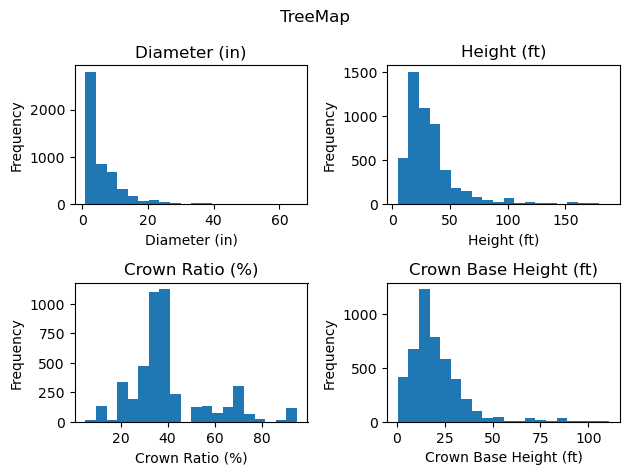

In [18]:
plot_hist(fftl_treemap_gpd, 'TreeMap')

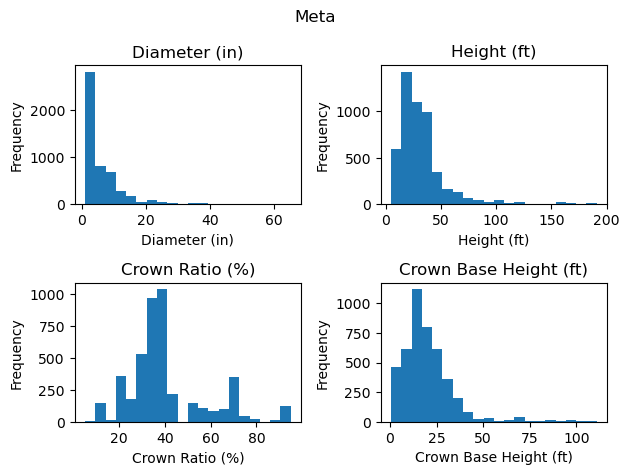

In [19]:
plot_hist(fftl_meta_gpd, 'Data Fusion')

#### Bubble plots

In [20]:
# summarize treelist to create bubble plots

def summarize_treelist(fftl):

    #add diameter in inches
    
    fftl['DIA_in'] = fftl['DIA'] / 2.54

    conditions = [
        (fftl['DIA_in'] < 2),
        (fftl['DIA_in'] >= 2) & (fftl['DIA_in'] < 4),
        (fftl['DIA_in'] >= 4) & (fftl['DIA_in'] < 8),
        (fftl['DIA_in'] >= 8) & (fftl['DIA_in'] < 12),
        (fftl['DIA_in'] >= 12) & (fftl['DIA_in'] < 16),
        (fftl['DIA_in'] >= 16) & (fftl['DIA_in'] < 20),
        (fftl['DIA_in'] >= 20)
    ]
    choices = ['0-2', '2-4', '4-8', '8-12', '12-16', '16-20', '20+']
    
    fftl['diam_group'] = np.select(conditions, choices, default='NA')
    fftl['CBH'] = (1 - fftl.CR) * fftl.HT 

    #summarize treelist
    fftl_subset = fftl.groupby(['diam_group'])[['HT', 'CR', 'CBH']].mean().reset_index()

    #add the trees per acre
    domain_size = boundary_5070.area[0]/4047
    
    fftl_subset['TPA'] = fftl.groupby(['diam_group'])['TREE_ID'].count().reset_index()['TREE_ID']/domain_size
    fftl_subset = fftl_subset.set_index('diam_group').reindex(choices).reset_index()

    return(fftl_subset)

fftl_treemap_subset = summarize_treelist(fftl_treemap_gpd)
fftl_meta_subset = summarize_treelist(fftl_meta_gpd)


In [21]:

def bubble_plot(x, y, df, xlabel, ylabel, method):
    choices = ['0-2', '2-4', '4-8', '8-12', '12-16', '16-20', '20+']

    fig, ax = plt.subplots()
    
    scatter = ax.scatter(x, y, 
                edgecolor = 'darkgray',
                s = df.TPA, 
                c =df.index, 
                cmap = 'YlGn')
    handles_c, labels_c = scatter.legend_elements()
    
    # legend for diameter (color)
    legend1 = ax.legend(
        handles_c, 
        choices, 
        loc="upper left", 
        title="Diameter",
        bbox_to_anchor=(1, 0.7)
    )
    ax.add_artist(legend1) # Add the first legend back to the plot
    
    # legend for trees per acre (size)
    handles_s, labels_s = scatter.legend_elements(prop="sizes", alpha=0.6, num=3)
    legend2 = ax.legend(
        handles_s, 
        labels_s, 
        # loc=" left", 
        bbox_to_anchor=(1, 0.9),
        loc = 'center left',
        title="Trees per Acre"
    )
    
    
    # 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"Mean {xlabel} vs Mean {ylabel} - {method}")
    # ax.grid(True)
    
    # plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust the plot area (rect=[left, bottom, right, top])
    plt.show()

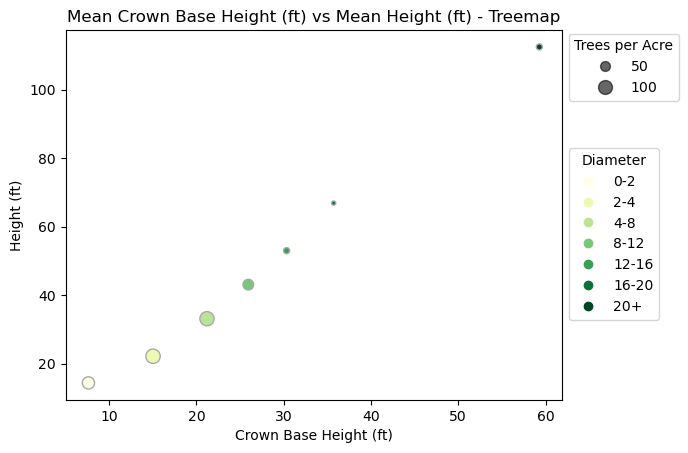

In [22]:
x = fftl_treemap_subset.CBH * 3.281
y = fftl_treemap_subset.HT * 3.281
df = fftl_treemap_subset
xlabel = 'Crown Base Height (ft)'
ylabel = 'Height (ft)'

bubble_plot(x, y, df, xlabel, ylabel, 'Treemap')

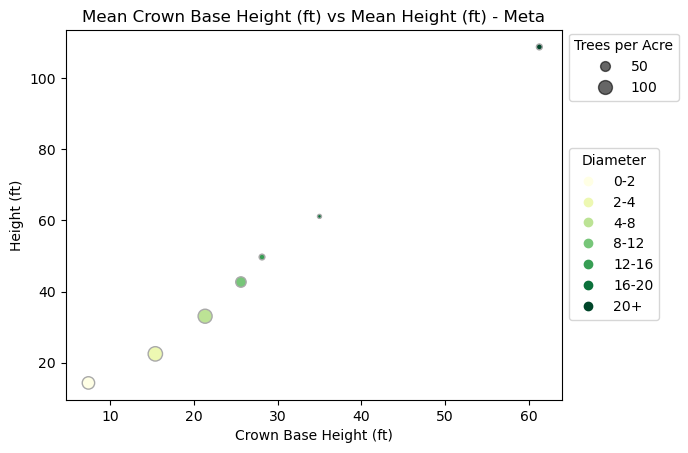

In [23]:
x = fftl_meta_subset.CBH * 3.281
y = fftl_meta_subset.HT * 3.281
df = fftl_meta_subset
xlabel = 'Crown Base Height (ft)'
ylabel = 'Height (ft)'

bubble_plot(x, y, df, xlabel, ylabel, 'Data Fusion')

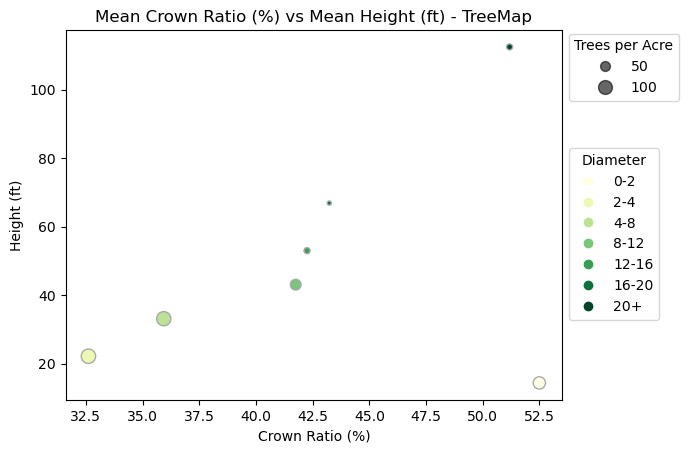

In [24]:
x = fftl_treemap_subset.CR * 100
y = fftl_treemap_subset.HT * 3.281
df = fftl_treemap_subset
xlabel = 'Crown Ratio (%)'
ylabel = 'Height (ft)'

bubble_plot(x, y, df, xlabel, ylabel, 'TreeMap')

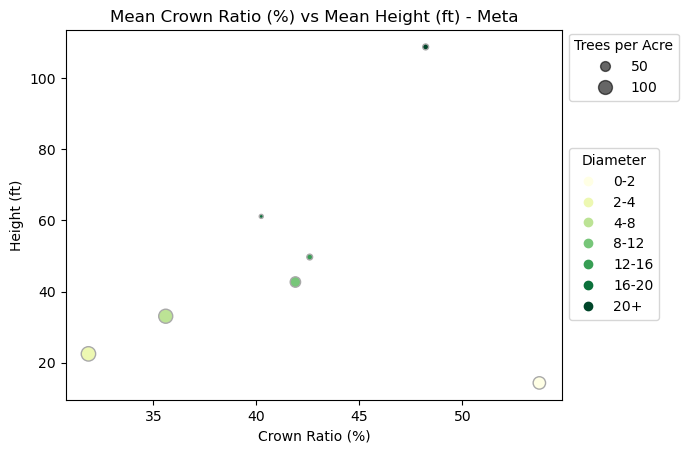

In [25]:
x = fftl_meta_subset.CR * 100
y = fftl_meta_subset.HT * 3.281
df = fftl_meta_subset
xlabel = 'Crown Ratio (%)'
ylabel = 'Height (ft)'

bubble_plot(x, y, df, xlabel, ylabel, 'Data Fusion')

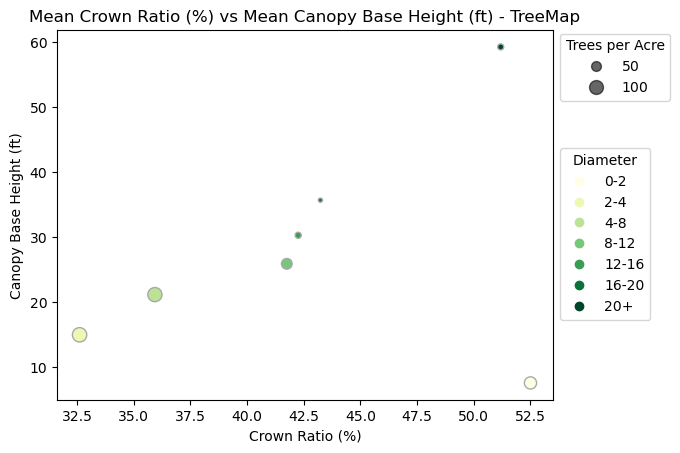

In [26]:
x = fftl_treemap_subset.CR * 100
y = fftl_treemap_subset.CBH * 3.281
df = fftl_treemap_subset
xlabel = 'Crown Ratio (%)'
ylabel = 'Canopy Base Height (ft)'

bubble_plot(x, y, df, xlabel, ylabel, 'TreeMap')

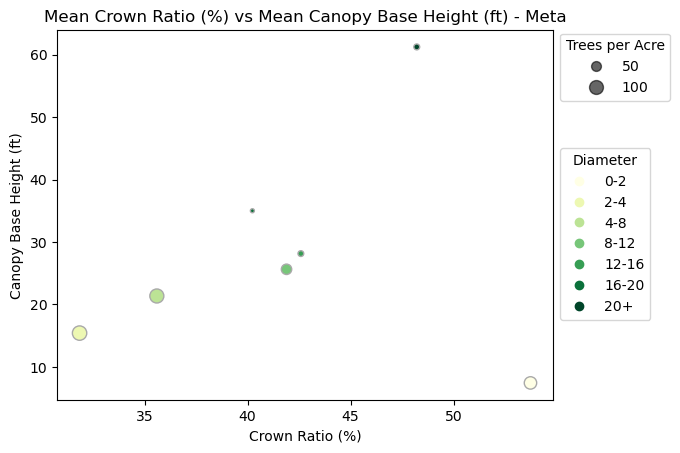

In [27]:
x = fftl_meta_subset.CR * 100
y = fftl_meta_subset.CBH * 3.281
df = fftl_meta_subset
xlabel = 'Crown Ratio (%)'
ylabel = 'Canopy Base Height (ft)'

bubble_plot(x, y, df, xlabel, ylabel, 'Data Fusion')

#### Surface Fuels
Surface fuels are from LANDFIRE

In [1]:
import zarr

In [2]:
treemap_zarr = zarr.open('workflow_1_treemap.zarr.zip')
meta_zarr = zarr.open('workflow_2_meta.zarr.zip')

In [3]:
#see the structure of the zarr folder
meta_zarr.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='feature', nodes=(Node(disabled=True…

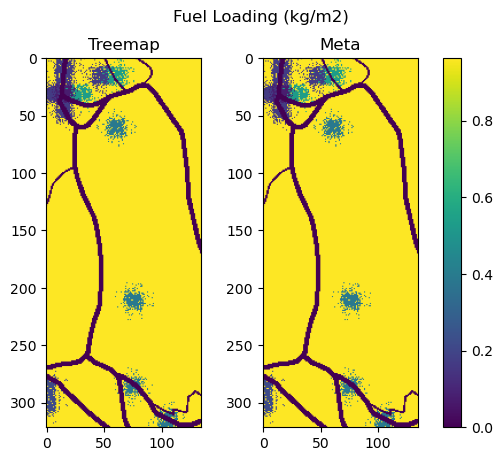

In [7]:
# Fuel loading
treemap_fl = treemap_zarr['surface']['fuelLoad']['oneHour'][...]
meta_fl = meta_zarr['surface']['fuelLoad']['oneHour'][...]

fig,axes = plt.subplots(1,2)

im1 = axes[0].imshow(treemap_fl)
axes[0].set_title('LANDFIRE')
im2 = axes[1].imshow(meta_fl)
axes[1].set_title('FCCS')

fig.colorbar(im1, ax=axes.ravel().tolist()) # Use ravel() for all axes
# plt.tight_layout()
fig.suptitle('Fuel Loading (kg/m2)')
plt.show()


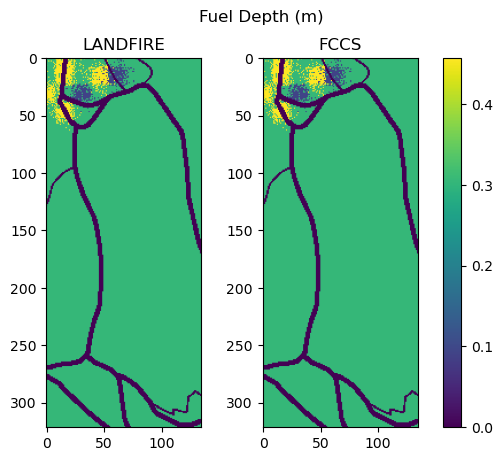

In [8]:
# Fuel depth
treemap_fd = treemap_zarr['surface']['fuelDepth'][...]
meta_fd = meta_zarr['surface']['fuelDepth'][...]

fig,axes = plt.subplots(1,2)

im1 = axes[0].imshow(treemap_fd)
axes[0].set_title('LANDFIRE')
im2 = axes[1].imshow(meta_fd)
axes[1].set_title('FCCS')

fig.colorbar(im1, ax=axes.ravel().tolist()) # Use ravel() for all axes
# plt.tight_layout()
fig.suptitle('Fuel Depth (m)')
plt.show()


#### Canopy Fuels

##### Canopy Height Model

In [9]:
# canopy height model based on the bulk density - calculate the height of the 
# highest non zero bulk density value

# vertical profile sums up the data in each layer to see how much fuel there is

# treemap
data = treemap_zarr['tree']['bulkDensity'][1:,...]
reversed_voxels = data[::-1, :, :]
heightmap = np.argmax(reversed_voxels, axis=0)
chm_nan_treemap = np.where(heightmap == 0, np.nan, heightmap)

treemap_profile = np.sum(data[1:], axis=(1, 2))
valid_indices = np.where(treemap_profile >= 0.1)[0]
treemap_z_levels = np.arange(1, treemap_profile.shape[0] + 1) 


# meta
data = meta_zarr['tree']['bulkDensity'][1:,...]
reversed_voxels = data[::-1, :, :]
heightmap = np.argmax(reversed_voxels, axis=0)
chm_nan_zarr = np.where(heightmap == 0, np.nan, heightmap)

meta_profile = np.sum(data[1:], axis=(1, 2))
valid_indices = np.where(meta_profile >= 0.1)[0]
meta_z_levels = np.arange(1, meta_profile.shape[0] + 1) 

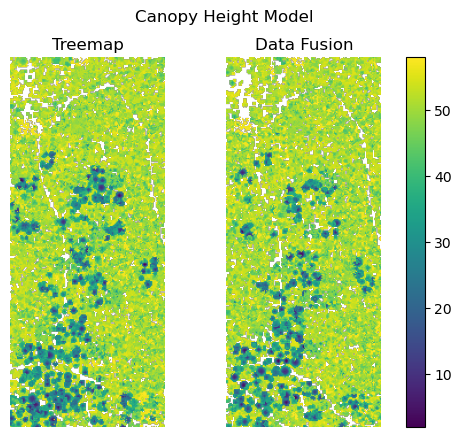

In [11]:

vmin = np.nanmin([chm_nan_treemap, chm_nan_zarr])
vmax = np.nanmax([chm_nan_treemap, chm_nan_zarr])

fig,axes = plt.subplots(1,2)

im1 = axes[0].imshow(chm_nan_treemap, vmin = vmin, vmax = vmax)
axes[0].set_title('Treemap')
im2 = axes[1].imshow(chm_nan_zarr, vmin = vmin, vmax = vmax)
axes[1].set_title('Data Fusion')
axes[0].axis('off')
axes[1].axis('off')

fig.colorbar(im1, ax=axes.ravel().tolist()) # Use ravel() for all axes
# plt.tight_layout()
fig.suptitle('Canopy Height Model')

plt.show()


##### Vertical profile distribution

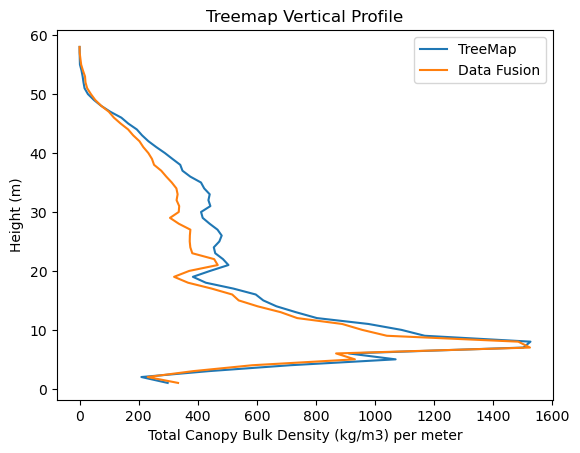

In [13]:
plt.plot(treemap_profile, treemap_z_levels, label = 'TreeMap')
plt.plot(meta_profile, meta_z_levels, label = 'Data Fusion')


plt.xlabel('Total Canopy Bulk Density (kg/m3) per meter')
plt.ylabel('Height (m)')
plt.title('Treemap Vertical Profile')
plt.legend()

### Access results from BP3D

In [ ]:
# from multipl ensembles, we can go through the runs of each ensemble and extract the outputs using BP3D SDK
ensemble_names = ['Treemap', 'Data Fusion']

In [ ]:
surface_consumption=[]
midstory_consumption=[]
canopy_consumption=[]

# set up the BP3D Client
c = bp3d.Client(user=user, password=password)

for n, ensemble_name in enumerate(ensemble_names):
    plan = c.plan(ensemble_name)
    ens = plan.ensemble(ensemble_name)
    runs_df = ens.runs_df
    runs_df = runs_df.reset_index()
    
    for i in np.arange(ens.runs_df.shape[0]):
        
        edf = runs_df.iloc[i]
    
        surface_consumption.append(edf.metrics['inside_surface_consumption'])
        midstory_consumption.append(np.sum(edf.metrics['consumption_t0_tNone_z1_z5']))
        canopy_consumption.append(np.sum(edf.metrics['consumption_t0_tNone_z6_zNone']))

In [39]:
pd.DataFrame({'Fuel Tile':ensemble_names,
 'Surface Consumption':surface_consumption,
 'Midstory Consumption': midstory_consumption,
 'Canopy Consumption': canopy_consumption
})

,Fuel Tile,Surface Consumption,Midstory Consumption,Canopy Consumption
0,Treemap,0.873533,0.100691,0.000004
1,Meta,0.873966,0.097092,0.000004
